In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null



In [2]:
!wget -q https://downloads.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz


In [3]:
!tar -xvf spark-3.3.2-bin-hadoop3.tgz


spark-3.3.2-bin-hadoop3/
spark-3.3.2-bin-hadoop3/LICENSE
spark-3.3.2-bin-hadoop3/NOTICE
spark-3.3.2-bin-hadoop3/R/
spark-3.3.2-bin-hadoop3/R/lib/
spark-3.3.2-bin-hadoop3/R/lib/SparkR/
spark-3.3.2-bin-hadoop3/R/lib/SparkR/DESCRIPTION
spark-3.3.2-bin-hadoop3/R/lib/SparkR/INDEX
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/Rd.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/features.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/hsearch.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/links.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/nsInfo.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/package.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/vignette.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/NAMESPACE
spark-3.3.2-bin-hadoop3/R/lib/SparkR/R/
spark-3.3.2-bin-hadoop3/R/lib/SparkR/R/SparkR
spark-3.3.2-bin-hadoop3/R/lib/SparkR/R/SparkR.rdb
spark-3.3.2-bin-hadoop3/R/lib/SparkR/R/SparkR.rdx
spark-3.3.2-bin-hadoop3/R/lib/SparkR/doc/
spark-3.3.2-bin-hadoop3/R/lib/Spar

In [4]:
!pip install -q findspark

In [5]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"
import findspark
findspark.init()

In [6]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession,SQLContext
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd   
import plotly.graph_objects as go
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from pyspark.sql.types import IntegerType
import seaborn as sns
import re
from textblob import TextBlob

In [7]:
conf = SparkConf().setMaster("local").setAppName("Weather analysis")  
from sklearn.metrics import mean_squared_error      #for reading & storing data, pre-processing
pd.set_option('display.float_format', lambda x: '%.5f' % x)


In [8]:
sc = SparkContext(conf = conf)
spark = SparkSession(sc)

In [9]:
sqlContext = SQLContext(sc)

In [10]:
#Reading the dataset
df = spark.read.option("header",'true').csv("city_temperature.csv",inferSchema=True)

In [11]:
print(df.dtypes)

[('Region', 'string'), ('Country', 'string'), ('State', 'string'), ('City', 'string'), ('Month', 'int'), ('Day', 'int'), ('Year', 'int'), ('AvgTemperature', 'double')]


In [12]:
#Convert the data into a pandas dataframe 
df=df.toPandas()

In [13]:
df.isna().sum()

Region                  0
Country                 0
State             1450990
City                    0
Month                   0
Day                     0
Year                    0
AvgTemperature          0
dtype: int64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906327 entries, 0 to 2906326
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Region          object 
 1   Country         object 
 2   State           object 
 3   City            object 
 4   Month           int32  
 5   Day             int32  
 6   Year            int32  
 7   AvgTemperature  float64
dtypes: float64(1), int32(3), object(4)
memory usage: 144.1+ MB


In [15]:
df.describe()

,Month,Day,Year,AvgTemperature
count,2906327.00000,2906327.00000,2906327.00000,2906327.00000
mean,6.46916,15.71682,2006.62391,56.00492
std,3.45649,8.80053,23.38226,32.12359
min,1.00000,0.00000,200.00000,-99.00000
25%,3.00000,8.00000,2001.00000,45.80000
50%,6.00000,16.00000,2007.00000,62.50000
75%,9.00000,23.00000,2013.00000,75.50000
max,12.00000,31.00000,2020.00000,110.00000


In [16]:
df["Region"].value_counts()

North America                        1556681
Europe                                381990
Asia                                  316663
Africa                                251118
South/Central America & Carribean     219530
Middle East                           124749
Australia/South Pacific                55596
Name: Region, dtype: int64

In [17]:
df["Country"].value_counts()

US                   1455337
Canada                 74245
Australia              46330
China                  46329
India                  37063
                      ...   
Guyana                  5065
Israel                  4641
Burundi                 4543
Georgia                 4378
Serbia-Montenegro       3427
Name: Country, Length: 125, dtype: int64

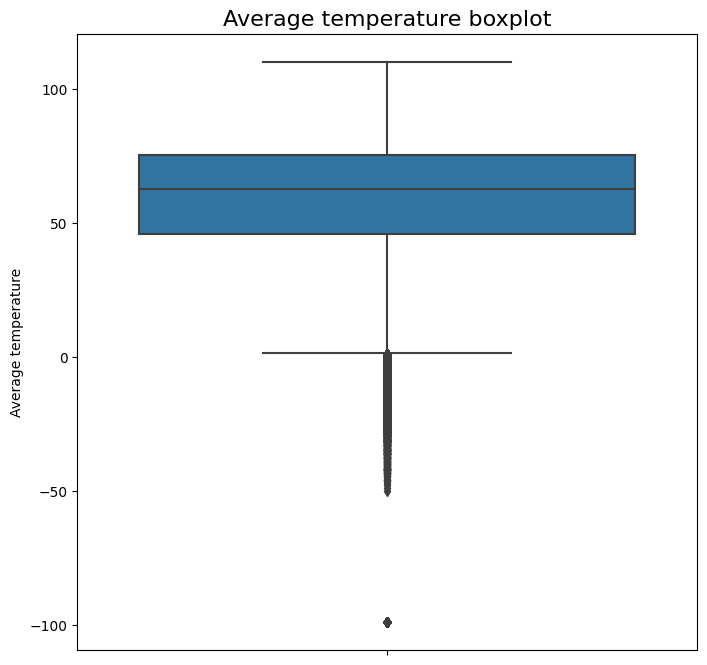

In [18]:
plt.figure(figsize= (8, 8))
ax = sns.boxplot(data= df, y= 'AvgTemperature')
ax.set_title('Average temperature boxplot', fontsize= 16)
ax.set_ylabel('Average temperature')
plt.show()

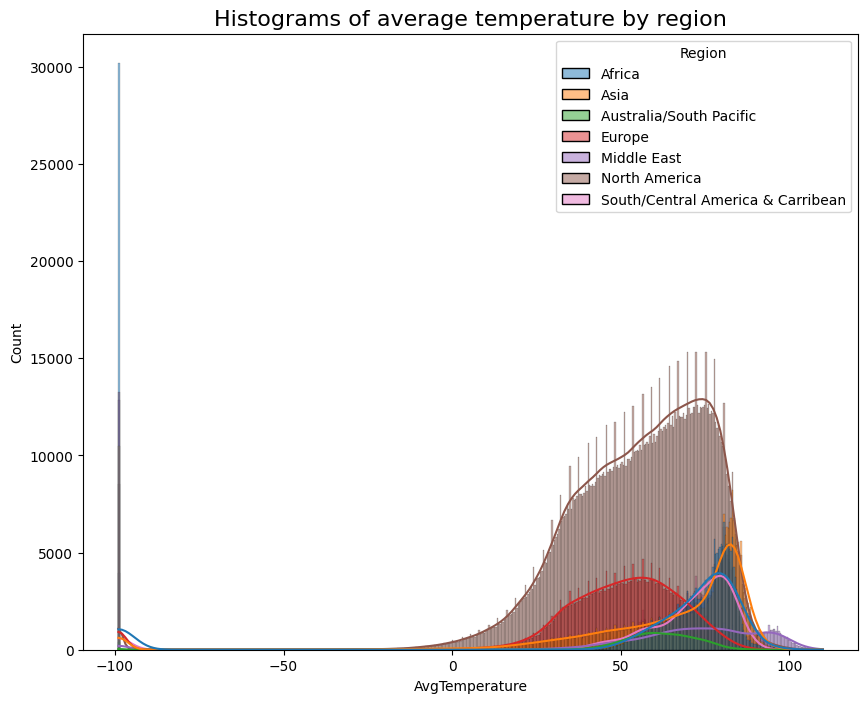

In [19]:
plt.figure(figsize= (10, 8))
ax = sns.histplot(data= df, x= 'AvgTemperature', hue= 'Region', kde= True)
ax.set_title('Histograms of average temperature by region', fontsize= 16)
plt.show()

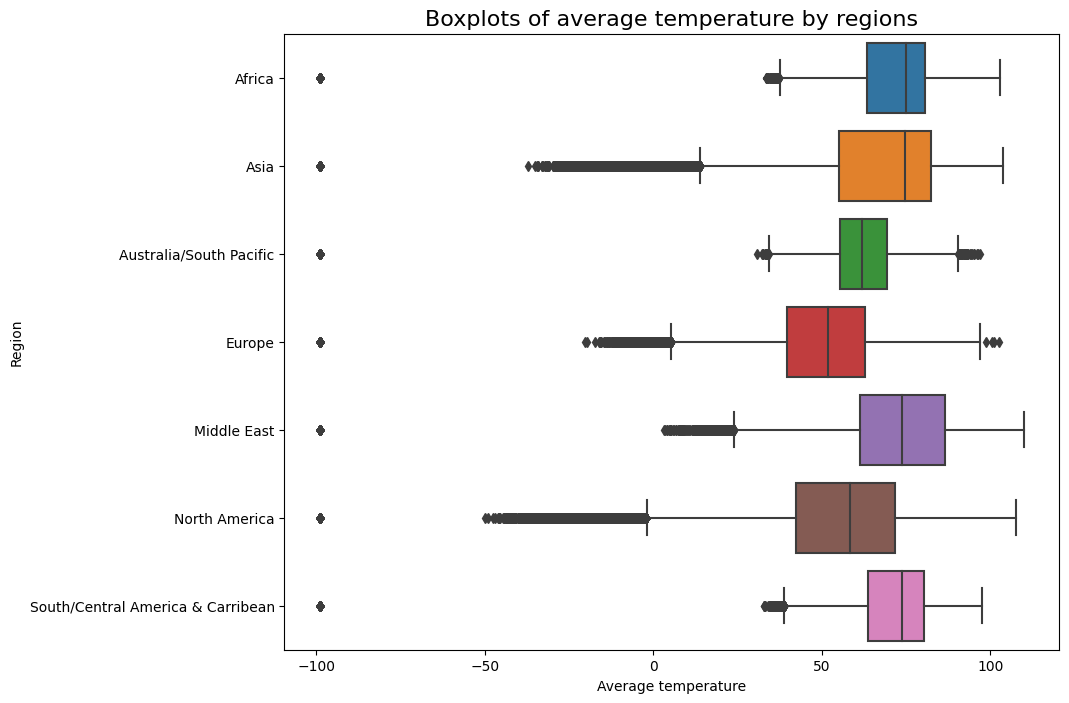

In [20]:
plt.figure(figsize= (10, 8))
ax = sns.boxplot(data= df, x= 'AvgTemperature', y= 'Region')
ax.set_title('Boxplots of average temperature by regions', fontsize= 16)
ax.set_ylabel('Region')
ax.set_xlabel('Average temperature')
plt.show()

In [21]:
#Choosing only the rows with India from the dataframe
data_India  = df[ (df['Country'] == 'India') & (df['Year'] < 2020)]

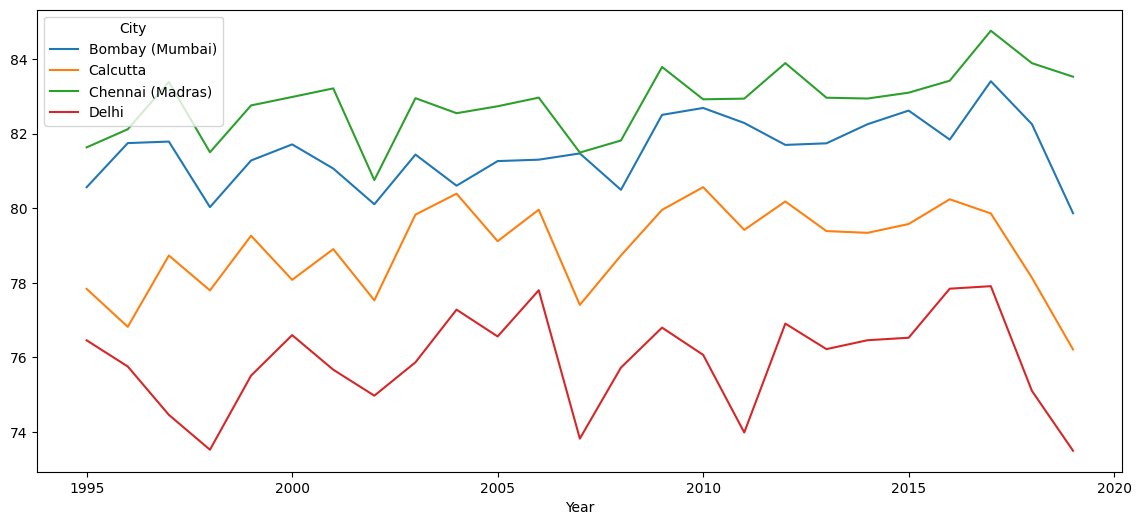

In [22]:
#plot for 4 cities and comparison of their temparatures
India_plot=data_India.groupby(['City','Year'])['AvgTemperature'].mean().reset_index()
India_plot.pivot('Year','City','AvgTemperature').plot()
plt.gcf().set_size_inches(14,6)

plt.show()

In [23]:
#creating variable 'season'
def season(df):
    if df in [12,1,2] :
        return 'Winter'
    elif  df in [3,4,5]:
        return 'Summer'
    elif df in [6,7,8]:
        return 'Monsoon'
    elif df in [9,10,11]:
        return 'Autumn'
    else:
        return 'NA'


In [24]:
pd.options.mode.chained_assignment = None  # default='warn'
data_India['Season'] = data_India['Month'].apply(season)

In [25]:
data_India['AvgTemperature']=data_India['AvgTemperature'].astype('float64')
data_India[['Month' , 'Day' , 'Year']]=data_India[['Month' , 'Day' , 'Year']].astype('int64')


In [26]:
#Seasons in Delhi
data_Delhi = data_India[data_India['City'] == 'Delhi']

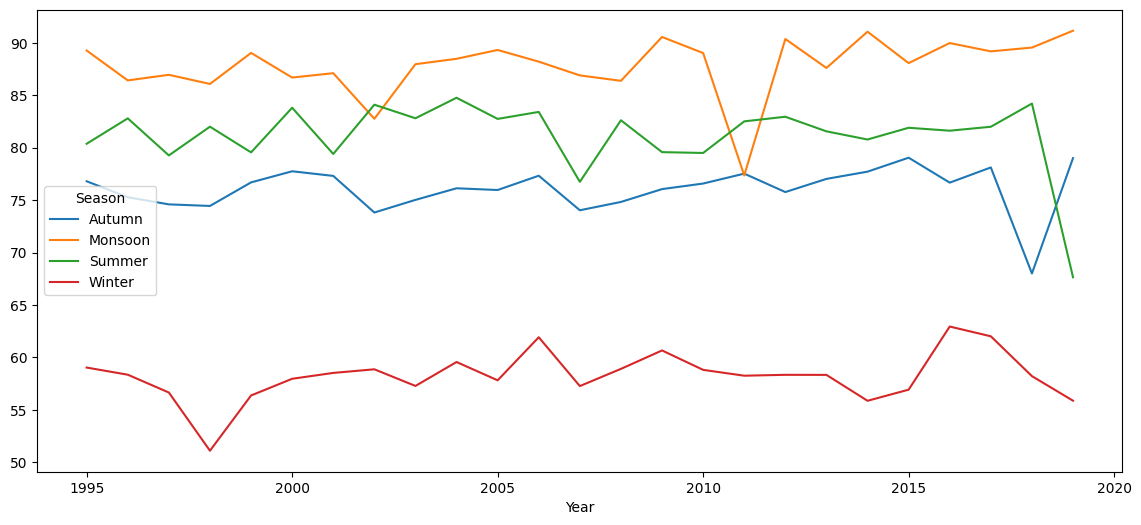

In [27]:
#Plot the seasons
Delhi_plot=data_Delhi.groupby(['Season','Year'])['AvgTemperature'].mean().reset_index()
Delhi_plot.pivot('Year','Season','AvgTemperature').plot()
plt.gcf().set_size_inches(14,6)

plt.show()


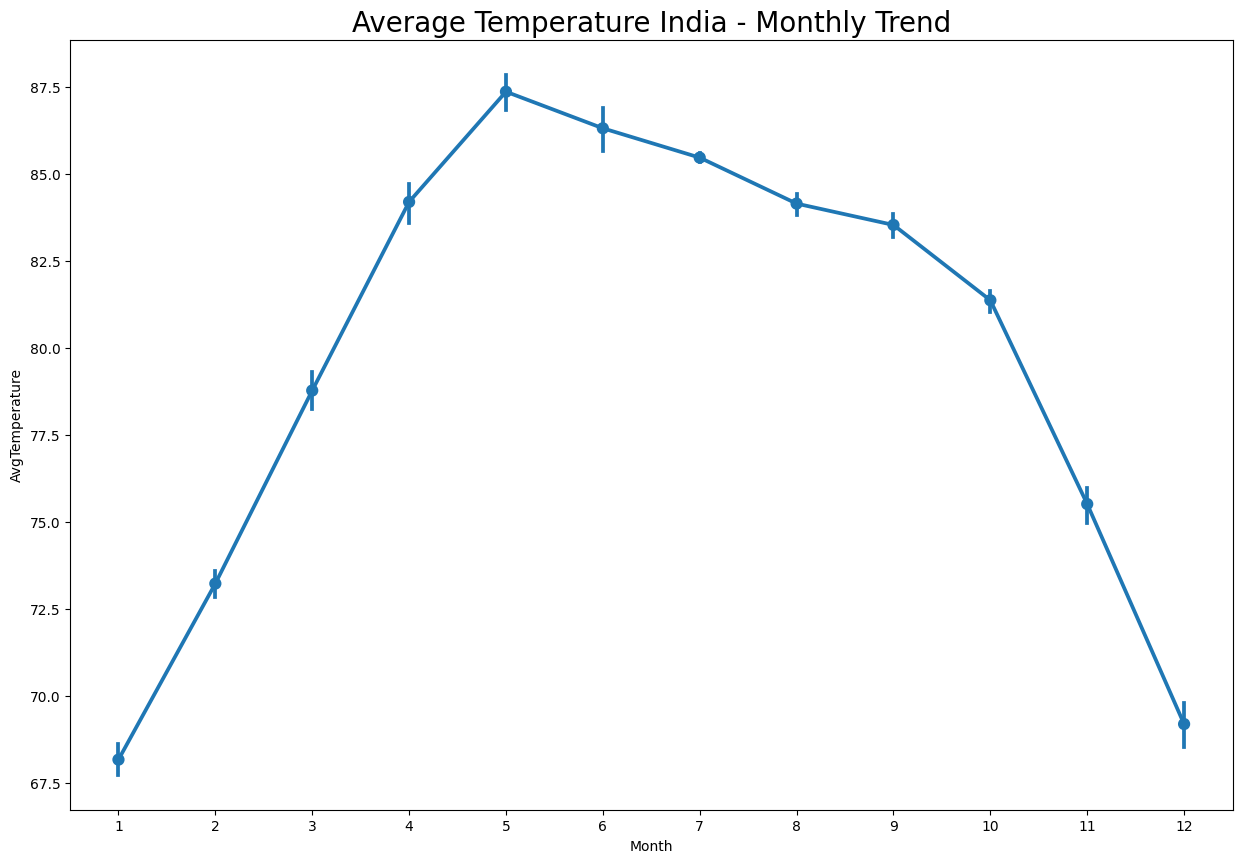

In [28]:
#Average temparature monthly in India
plt.figure(figsize= (15,10))
sns.pointplot(x='Month', y='AvgTemperature', data=data_India);
plt.title('Average Temperature India - Monthly Trend',fontsize=20);


In [29]:
Average_Temperture_in_every_region = df.groupby("Region")["AvgTemperature"].mean().sort_values()[-1::-1]
Average_Temperture_in_every_region = Average_Temperture_in_every_region.rename({"South/Central America & Carribean":"South America","Australia/South Pacific":"Australia"})
Average_Temperture_in_every_region

Region
Middle East     68.38455
Asia            62.56865
South America   62.18944
Australia       61.18087
North America   55.30093
Africa          53.54952
Europe          46.69629
Name: AvgTemperature, dtype: float64

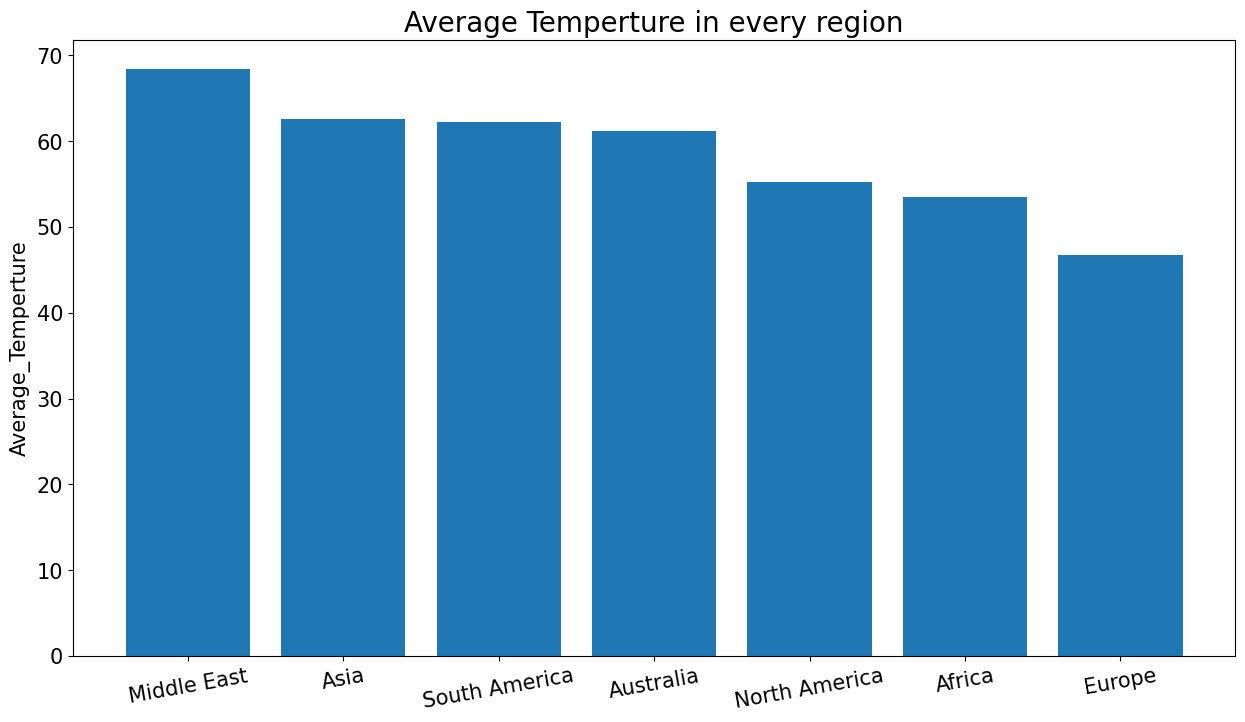

In [30]:
fig3= plt.figure(figsize = (15,8))
plt.bar(Average_Temperture_in_every_region.index,Average_Temperture_in_every_region.values)
plt.xticks(rotation = 10,size = 15)
plt.yticks(size = 15)
plt.ylabel("Average_Temperture",size = 15)
plt.title("Average Temperture in every region",size = 20)

plt.show()


In [31]:
#dropping the State column as it has many null values
df.drop('State',axis='columns', inplace=True)

In [32]:
#Keeping only rows for Delhi
delhi = df[df["City"] == "Delhi"]
delhi.reset_index(inplace = True)
delhi.drop('index', axis = 1, inplace=True)
print(delhi.describe())

           Month        Day       Year  AvgTemperature
count 9265.00000 9265.00000 9265.00000      9265.00000
mean     6.46908   15.71765 2007.18683        75.79886
std      3.45748    8.80195    7.32454        19.31898
min      1.00000    1.00000 1995.00000       -99.00000
25%      3.00000    8.00000 2001.00000        65.00000
50%      6.00000   16.00000 2007.00000        80.50000
75%      9.00000   23.00000 2014.00000        87.50000
max     12.00000   31.00000 2020.00000       103.70000


In [33]:
#Replacing outliers with mean
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
delhi["AvgTemperature"] = pd.to_numeric(delhi["AvgTemperature"], errors='coerce')

# Replace missing values with the mean temperature
delhi["AvgTemperature"].replace(-99, np.mean(delhi["AvgTemperature"]), inplace=True)

# Impute missing values using SimpleImputer
imputer = SimpleImputer()
delhi["AvgTemperature"] = imputer.fit_transform(delhi[["AvgTemperature"]])


In [34]:
#Converting to datetime format
delhi['Date'] = pd.to_datetime(delhi[['Year','Month','Day']])
delhi = delhi.drop(['Region', 'Country', 'City','Month','Day'], axis = 1)
print(delhi.head())


   Year  AvgTemperature       Date
0  1995        50.70000 1995-01-01
1  1995        52.10000 1995-01-02
2  1995        53.80000 1995-01-03
3  1995        53.70000 1995-01-04
4  1995        54.50000 1995-01-05


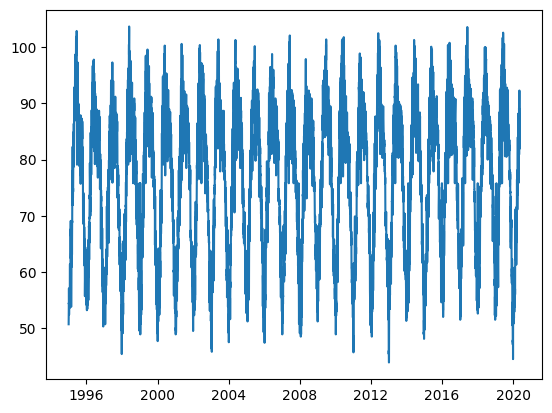

In [35]:
#Visualisation
fig4= plt.plot(delhi["Date"], delhi["AvgTemperature"])
plt.show()

In [36]:
#Defining training and testing data
training_set = delhi[delhi["Year"] <= 2015]
test_set = delhi[delhi["Year"] > 2015]

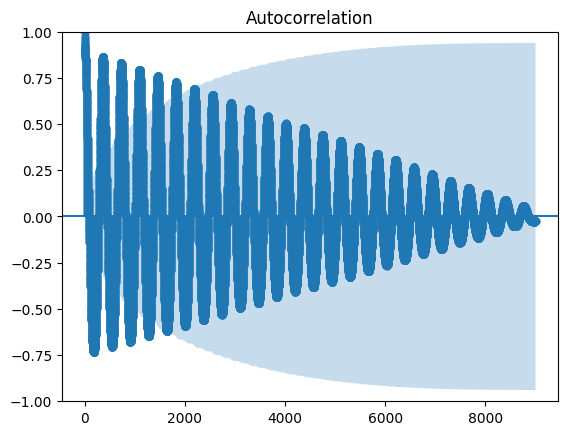

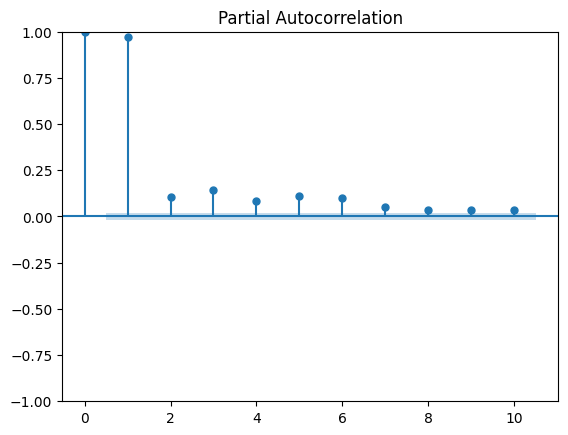

In [37]:
#acf and pacf plots
from statsmodels.graphics.tsaplots import plot_acf
acf=plot_acf(delhi["AvgTemperature"], lags = 9000)
from statsmodels.graphics.tsaplots import plot_pacf
pacf=plot_pacf(delhi["AvgTemperature"], lags = 10)

plt.show()

In [38]:
from statsmodels.tsa.arima_model import ARMA

In [39]:
import statsmodels.api as sm

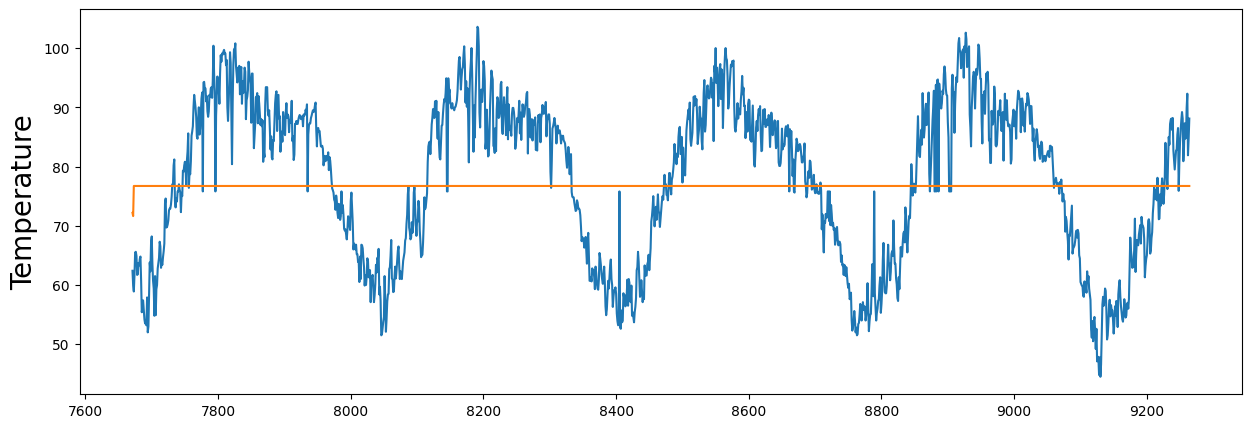

In [40]:
from statsmodels.tsa.arima.model import ARIMA

# Define the order of the ARIMA model
p = 0  # autoregressive order
d = 0  # differencing order
q = 2  # moving average order

# Create and fit the ARIMA model
model = ARIMA(training_set["AvgTemperature"], order=(p, d, q))
model_fit = model.fit()

# Generate predictions for the test set
start_idx = test_set.index[0]
end_idx = test_set.index[-1]
predictions_ARMA = model_fit.predict(start_idx, end_idx)

# Print the predictions
fig5=plt.figure(figsize=(15,5))
plt.ylabel("Temperature",fontsize=20)
plt.plot(test_set["AvgTemperature"],label="Original Data")
plt.plot(predictions_ARMA,label="Predictions")
plt.show()
#plt.legend()

In [41]:
rmse = mean_squared_error(predictions_ARMA,test_set["AvgTemperature"])
print(rmse**0.5)

13.279472892146584


In [42]:
accuracy = 100 * (1 - (rmse / test_set.count()))
print(accuracy)

Year             88.93699
AvgTemperature   88.93699
Date             88.93699
dtype: float64


In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Calculate the metrics
mae = mean_absolute_error(test_set["AvgTemperature"], predictions_ARMA)
mse = mean_squared_error(test_set["AvgTemperature"], predictions_ARMA)
rmse = np.sqrt(mse)
r2 = r2_score(test_set["AvgTemperature"], predictions_ARMA)

# Print the metrics
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-squared:", r2)


MAE: 11.6340120302606
MSE: 176.34440029325597
RMSE: 13.279472892146584
R-squared: -0.007641128489908278
